A notebook for creating code to analyze the clustering of our experimental protein structures. Uses the analysis.yml environment.

In [10]:
# from biopandas.pdb import PandasPdb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial import distance_matrix
from statannotations.Annotator import Annotator
# from pymol import cmd
import scienceplots

In [11]:
pal2 = sns.color_palette('BuGn')
pal5 = sns.color_palette('PiYG')
pal6 = sns.color_palette('Blues')

In [22]:
plt.style.use('science')

plt.rcParams.update({'font.family': 'sans-serif'})

# Get the hex codes for the colors so we can assign them to categories
pal = sns.color_palette('Paired')
print(pal.as_hex())

# Set the color palette. Our categories are "Single Domain", "Two-Domain", and "Autoinhibited"
colors = {'Single Domain': pal[4], 'Two-Domain': pal[1], 'Autoinhibited': pal2[5], 'Full': pal[3],
        'Cluster': pal[2], 'Obligate': pal[7], 'Full Depth': pal[3], 'Cluster (w/ Uniform Clstrs.)': pal[11],
        'Cluster (w/o Uniform Clstrs.)': pal[10], 'AI Cluster': pal[2], 'TD Cluster': pal[0], 'TD Full Depth': pal[1], 'AI Full Depth': pal[3],
        'AI Cluster (w/ Uniform Clstrs.)': pal5[5], 'TD Cluster (w/ Uniform Clstrs.)': pal6[3], 'AI Cluster (w/o Uniform Clstrs.)': pal5[4],
        'TD Cluster (w/o Uniform Clstrs.)': pal6[2], 'Obligate Cluster (w/ Uniform Clstrs.)': pal[6], 'Obligate Full Depth': pal[7],
        'Accurate': pal[5], 'Inaccurate': pal[8], 'AI (AF2T)': pal2[5], 'TD (AF2T)': pal[1], 'AI (AF3T)': pal[3], 'TD (AF3T)': pal[1], 'AI (AF3)': pal[3],
        'TD (AF2)': pal[1], 'AI 2S (AF3)': pal[3], 'AI 2S (AF3T)': pal[3], 'AI 2S (AF2T)': pal2[5], 'AI 2S (CFold)': pal5[0], 'AI 2S (CFold T)': pal[3],
        'AI Cluster (AF2T)': pal2[5], 'TD Cluster (AF2)': pal[0], 'Obligate (AF2)': pal[7], 'AI (AF2)': pal2[5], 'Base': pal[5],
        'Alternate': pal[8], 'Both': pal[11], 'AI (AF2)': pal2[5], 'AI (AF3)': pal[3], 'Non-Homologous \nAI (AF2)': pal2[2], 'Non-Homologous \nAI (AF3)': pal2[1], 
        'TD (AF2)': pal[1], 'Autoinhibited (AF3)': pal[3], 'Autoinhibited (AF2)': pal2[5], 'Two-Domain (AF2)': pal[1], 'Obligate (AF2)': pal[7],
        'No partners/PTMs (AF2)': pal2[5], 'With partners/PTMs (AF2)': pal2[4], 'No partners/PTMs (AF3)': pal[3], 'With partners/PTMs (AF3)': pal2[3],
        'Non-Homologous \nAI (AF2T)': pal2[2], 'Non-Homologous \nAI (AF3T)': pal2[1],
        'Autoinhibited (AF2T)': pal2[5], 'Autoinhibited (AF3T)': pal[3], 'AI Uniform Clusters': pal5[5], 'AI Local Clusters': pal5[4]}
pal.as_hex()

['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']


['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

In [13]:
def num_clusters(df, max_d):
    uniprot = df['uniprot'].unique()
    array = df[['2_comp', 'complex_rmsd']].values

    Z = linkage(array, method='single', metric='euclidean')

    clusters = fcluster(Z, max_d, criterion='distance')
    max_cluster = max(clusters)

    return pd.DataFrame({'uniprot': uniprot, 'num_clusters': max_cluster})

def num_clusters_grmsd(df, max_d):
    '''
    df passed here must consist of the condensed distance matrix.
    '''

    uniprot = df['uniprot'].unique()
    array = np.reshape(df['complex_rmsd'].values, (len(df['complex_rmsd']), 1))

    Z = linkage(array, method='single', metric='euclidean')

    clusters = fcluster(Z, max_d, criterion='distance')
    max_cluster = max(clusters)

    return pd.DataFrame({'uniprot': uniprot, 'num_clusters': max_cluster})

def num_clusters_imfd(df, max_d):
    '''
    df passed here must consist of the condensed distance matrix.
    '''

    uniprot = df['uniprot'].unique()
    array = np.reshape(df['2_comp'].values, (len(df['2_comp']), 1))

    Z = linkage(array, method='single', metric='euclidean')

    clusters = fcluster(Z, max_d, criterion='distance')
    max_cluster = max(clusters)

    return pd.DataFrame({'uniprot': uniprot, 'num_clusters': max_cluster})

def produce_plot_dfs(ai_df, md_df, max_d, func):
    '''
    Take two dataframes, an Autoinhibited dataframe and a multi-domain dataframe, get the 
    number of clusters for each dataframe depending on the specified function, 
    and return a combined dataframe with the number of clusters
    '''

    ai_complex_clusters = pd.DataFrame()
    for uniprot in ai_df['uniprot'].unique():
        df = ai_df[ai_df['uniprot'] == uniprot].reset_index(drop=True)
        num_clusters_df = func(df, max_d)
        ai_complex_clusters = pd.concat([ai_complex_clusters, num_clusters_df])

    md_complex_clusters = pd.DataFrame()
    for uniprot in md_df['uniprot'].unique():
        df = md_df[md_df['uniprot'] == uniprot].reset_index(drop=True)
        num_clusters_df = func(df, max_d)
        md_complex_clusters = pd.concat([md_complex_clusters, num_clusters_df])

    ai_complex_clusters['type'] = 'Autoinhibited'
    md_complex_clusters['type'] = 'Two-Domain'

    return pd.concat([md_complex_clusters, ai_complex_clusters]).reset_index(drop=True)

def plot_clusters(df, ax):
    
    # sns.boxplot(data=df, x='type', y='num_clusters', hue='type', palette=colors, ax=ax, dodge=False)
    # ax.legend(title='Type', fontsize='12', title_fontsize='14', loc='upper right')

    # ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    # ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    # ax.set(xlabel=None, ylabel=None)
    # pairs = [('Autoinhibited', 'Two-Domain')]
    # annotator = Annotator(ax=ax, pairs=pairs, data=df, x='type', y='num_clusters')
    # annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    # annotator.apply_and_annotate()
    sns.histplot(data=df, x='num_clusters', hue='type', palette=colors, ax=ax, common_norm=False, stat='percent', multiple='dodge')
    # ax.legend(title='Type', fontsize='12', title_fontsize='14', loc='upper right')
    # ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    # ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set(xlabel=None, ylabel=None)

def plot_histograms(df, ax):
    
    sns.histplot(data=df, x='num_clusters', hue='type', palette=colors, ax=ax, common_norm=False)
    ax.legend(title='Type', fontsize='12', title_fontsize='14', loc='upper right', labels=['Two-Domain', 'Autoinhibited'])

    ax.set(xlabel=None, ylabel=None)

In [14]:
ai = pd.read_csv('./project_pipeline/data/classified_files.tsv', sep='\t')
multiple_prots = ai['uniprot'].value_counts()
multiple_prots = multiple_prots[multiple_prots > 1].index
multiple = ai[ai['uniprot'].isin(multiple_prots)].reset_index(drop=True)
multiple.shape

(837, 16)

In [15]:
md = pd.read_csv('./project_pipeline/data/md_rmsds.tsv', sep='\t')
multiple_md = md['uniprot'].value_counts()
multiple_md = multiple_md[multiple_md > 1].index
multiple_md = md[md['uniprot'].isin(multiple_md)].reset_index(drop=True)
multiple_md.shape

(172, 29)

In [16]:
k = 2

ail = [multiple, multiple]
mdl = [multiple_md, multiple_md]
max_dl = [1, 3]
funcl = [num_clusters_grmsd, num_clusters_imfd]

ai_dfs = [ele for ele in ail for i in range(k)]
md_dfs = [ele for ele in mdl for i in range(k)]
max_ds = [ele for ele in max_dl for i in range(k)]
funcs = [ele for i in range(k) for ele in funcl]

dfs = [produce_plot_dfs(ai_dfs[i], md_dfs[i], max_ds[i], funcs[i]) for i in range(len(ai_dfs))]

In [17]:
dfs[0].head()

,uniprot,num_clusters,type
0,D9N168,1,Two-Domain
1,Q72AS4,1,Two-Domain
2,P14677,2,Two-Domain
3,A0A0H2WY27,1,Two-Domain
4,Q51504,1,Two-Domain


<Figure size 4200x3150 with 0 Axes>

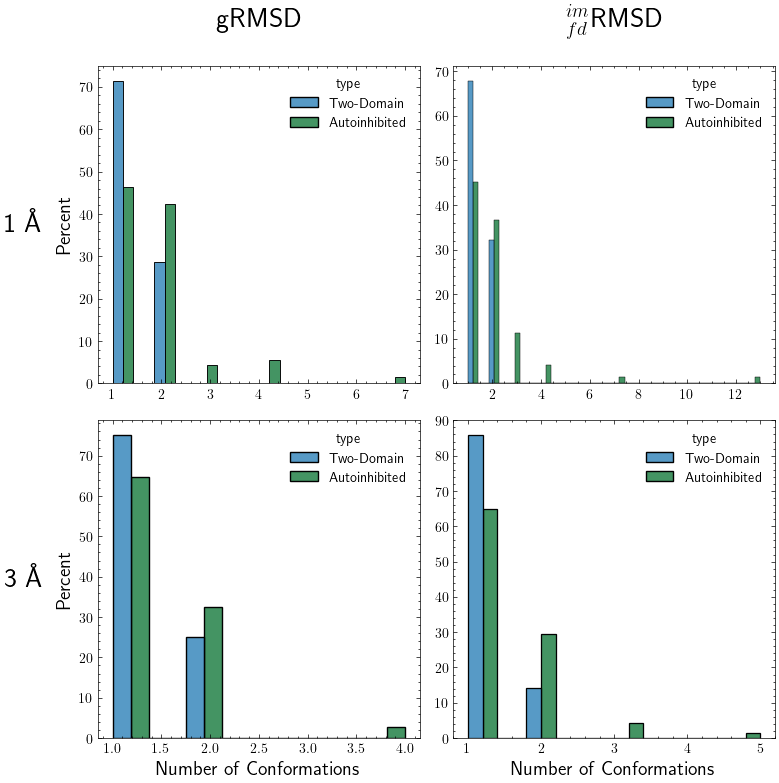

In [24]:
plt.figure(dpi=1200)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

dfs_axes = zip(dfs, axes.flatten())

for df, ax in dfs_axes:
    plot_clusters(df, ax)

cols = ['gRMSD', '$_{fd}^{im}$RMSD']
rows = ['1 Å', '3 Å']

pad = 5
for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1.1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=20, ha='center', va='baseline')
    
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=20, ha='right', va='center')
    
for ax in axes[:, 0]:
    ax.set_ylabel('Percent', fontsize=14)

for ax in axes[1]:
    ax.set_xlabel('Number of Conformations', fontsize=14)

plt.tight_layout()

plt.savefig('./project_pipeline/data/figures/paper/num_clusters.png', dpi=300)

In [ ]:
plt.figure(dpi=1200)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

dfs_axes = zip(dfs, axes.flatten())

for df, ax in dfs_axes:
    plot_histograms(df, ax)

cols = ['gRMSD', '$_{fd}^{im}$RMSD']
rows = ['1 Å', '3 Å']

pad = 5
for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1.1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=20, ha='center', va='baseline')
    
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=20, ha='right', va='center')
    
for ax in axes[:, 0]:
    ax.set_ylabel('Number of Clusters', fontsize=14)

for ax in axes[1]:
    ax.set_xlabel('Type', fontsize=14)

plt.tight_layout()

plt.savefig('./project_pipeline/data/figures/num_clusters_hist.png', dpi=1200)

In [9]:
ai_num_clusters = pd.DataFrame()

for uniprot in multiple['uniprot'].unique():
    df = multiple[multiple['uniprot'] == uniprot].reset_index(drop=True)
    num_clusters_df = num_clusters(df, 2)
    ai_num_clusters = pd.concat([ai_num_clusters, num_clusters_df])

In [10]:
md_num_clusters = pd.DataFrame()

for uniprot in multiple_md['uniprot'].unique():
    df = multiple_md[multiple_md['uniprot'] == uniprot].reset_index(drop=True)
    num_clusters_df = num_clusters(df, 2)
    md_num_clusters = pd.concat([md_num_clusters, num_clusters_df])

In [11]:
ai_num_clusters['type'] = 'Autoinhibited'
md_num_clusters['type'] = 'Two-Domain'

plot = pd.concat([ai_num_clusters, md_num_clusters]).reset_index(drop=True)

In [ ]:
perc = plot.groupby('type')['num_clusters'].value_counts(normalize=True).reset_index(name='Percent')

fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=plot, x='type', y='num_clusters', hue='type', palette=colors, ax=ax, dodge=False)
ax.legend(title='Type', fontsize='12', title_fontsize='14', loc='upper right')
ax.set_xlabel('Number of Clusters', fontsize='14')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

pairs = [('Autoinhibited', 'Two-Domain')]
annotator = Annotator(ax=ax, pairs=pairs, data=plot, x='type', y='num_clusters')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

In [ ]:
ai_complex_clusters = pd.DataFrame()
for uniprot in multiple['uniprot'].unique():
    df = multiple[multiple['uniprot'] == uniprot].reset_index(drop=True)
    num_clusters_df = num_clusters_grmsd(df, 2)
    ai_complex_clusters = pd.concat([ai_complex_clusters, num_clusters_df])
ai_complex_clusters

In [14]:
md_complex_clusters = pd.DataFrame()

for uniprot in multiple_md['uniprot'].unique():
    df = multiple_md[multiple_md['uniprot'] == uniprot].reset_index(drop=True)
    num_clusters_df = num_clusters_grmsd(df, 2)
    md_complex_clusters = pd.concat([md_complex_clusters, num_clusters_df])

ai_complex_clusters['type'] = 'Autoinhibited'
md_complex_clusters['type'] = 'Two-Domain'

complex_plot = pd.concat([ai_complex_clusters, md_complex_clusters]).reset_index(drop=True)

In [ ]:
# perc = plot.groupby('type')['num_clusters'].value_counts(normalize=True).reset_index(name='Percent')

fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=complex_plot, x='type', y='num_clusters', hue='type', palette=colors, ax=ax, dodge=False)
ax.legend(title='Type', fontsize='12', title_fontsize='14', loc='upper right')
ax.set_xlabel('Number of Clusters', fontsize='14')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

pairs = [('Autoinhibited', 'Two-Domain')]
annotator = Annotator(ax=ax, pairs=pairs, data=complex_plot, x='type', y='num_clusters')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

In [16]:
ai_imfd_clusters = pd.DataFrame()

for uniprot in multiple['uniprot'].unique():
    df = multiple[multiple['uniprot'] == uniprot].reset_index(drop=True)
    ai_num_clusters = num_clusters_imfd(df, 3)
    ai_imfd_clusters = pd.concat([ai_imfd_clusters, ai_num_clusters])

md_imfd_clusters = pd.DataFrame()

for uniprot in multiple_md['uniprot'].unique():
    df = multiple_md[multiple_md['uniprot'] == uniprot].reset_index(drop=True)
    md_num_clusters = num_clusters_imfd(df, 3)
    md_imfd_clusters = pd.concat([md_imfd_clusters, md_num_clusters])

ai_imfd_clusters['type'] = 'Autoinhibited'
md_imfd_clusters['type'] = 'Two-Domain'

imfd_plot = pd.concat([ai_imfd_clusters, md_imfd_clusters]).reset_index(drop=True)

In [ ]:
# perc = plot.groupby('type')['num_clusters'].value_counts(normalize=True).reset_index(name='Percent')

fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=imfd_plot, x='type', y='num_clusters', hue='type', palette=colors, ax=ax, dodge=False)
ax.legend(title='Type', fontsize='12', title_fontsize='14', loc='upper right')
ax.set_xlabel('Number of Clusters', fontsize='14')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

pairs = [('Autoinhibited', 'Two-Domain')]
annotator = Annotator(ax=ax, pairs=pairs, data=imfd_plot, x='type', y='num_clusters')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()